In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install torchaudio

     |████████████████████████████████| 3.2MB 2.8MB/s 


# Part 1: A speech classification training loop, implementing a ConvNet, computing WER

This includes 4 exercises: sections 1.3, 1.4, 1.5, 1.6. This doc can be helpful https://pytorch.org/docs/stable/index.html

## 1.1 Loading the dataset

In [2]:
import torchaudio
import torch
from torchaudio.datasets import YESNO, LIBRISPEECH
from torch.utils.data import DataLoader

In [3]:
def collate_fn(batch):
  tensors = [b[0].t() for b in batch if b]
  tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
  tensors = tensors.transpose(1, -1)

  targets = torch.tensor([b[2] for b in batch if b])
  targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

  return tensors, targets

dataset = YESNO(".", download=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True,
                                          num_workers=2, collate_fn=collate_fn)

## 1.2 Features

We are using standard speech features, do not worry about it today, we will come back to it in section 2 of the lab.

In [4]:
# Classic speech rec. features
melfbanks = torchaudio.transforms.MelSpectrogram(n_mels=80)

# The original/standard LibriSpeech SpecAugment policy:
# 80 Mel filters
# 2 frequency masks max 27 frequency bands out of 80
# 2 time masks max 100 timesteps (1 second)
# see https://arxiv.org/abs/1904.08779
timemasking = torchaudio.transforms.TimeMasking(100)
freqmasking = torchaudio.transforms.FrequencyMasking(27)

## 1.3 Model

**Exercise 1:** to start, we are working with the Yes/No dataset, that comprises always "yes" or "no" sequences of length exactly 8. Code a ConvNet based model which takes a variable length input, with 80 features (see above: 1.2 Features) and always output 8 (binary) values.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleConvNet(nn.Module):
  def __init__(self, kernel_size=3, stride=1, padding=1, depth=1):  ### Those are not good hyperparameters
    super(SimpleConvNet, self).__init__()
    self.conv1 = nn.Conv1d(in_channels=80, out_channels=6, kernel_size=kernel_size, stride= stride)
    self.conv2 = nn.Conv1d(in_channels=6, out_channels=12, kernel_size=kernel_size, stride= stride)
    
    self.fc1 = nn.Linear(in_features=12 * 60, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=16)
    self.out = nn.Linear(in_features=16, out_features=8)
    self.maxpool = nn.AdaptiveAvgPool1d(60)

  def forward(self, x):
        # (1) input layer
    x = x.squeeze()
    # (2) hidden conv layer
    x = self.conv1(x)
    x = F.relu(x)
    #x = F.max_pool1d(x, kernel_size=2, stride=2)

    # (3) hidden conv layer
    x = self.conv2(x)
    x = F.relu(x)
    
    x = self.maxpool(x)
    #x = F.max_pool1d(x, kernel_size=2, stride=2)

    # (4) hidden linear layer
    
    x = x.view(x.shape[0], -1)

    x = self.fc1(x)
    x = F.relu(x)

    # (5) hidden linear layer
    x = self.fc2(x)
    x = F.relu(x)

    # (6) output layer
    x = self.out(x)
    return x

model = SimpleConvNet()

## 1.4 Visualize features and network output

**Exercise 2:** visualize the input waveform, the MelSpectrogram features before and after data augmentation with SpecAugment, and the model's output (you could for instance use plt.plot, plt.imshow, plt.bar). Use this to debug your model's forward.

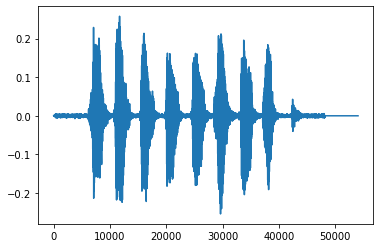

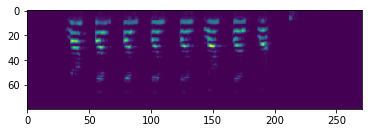

<Figure size 432x288 with 0 Axes>

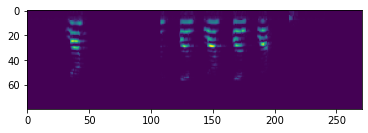

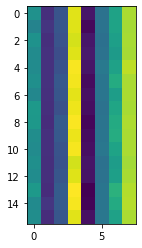

<Figure size 432x288 with 0 Axes>

In [6]:
from matplotlib import pyplot as plt
x, y = next(iter(data_loader))
x_ = x.squeeze(1)
plt.plot(x_[0])
# print(x_.shape)
# print(type(x), x.shape)
# print(type(y), y.shape)

plt.figure()
### TODO: visualize the waveform input
x = torch.log(1. + melfbanks(x))  # Those are the speech features we can train on
x_ = x.squeeze(1)
plt.imshow(x_[0])
plt.show()
plt.figure()
### TODO: visualize input features
x = timemasking(freqmasking(x))  # Those are the speech featues with some data augmentation (SpecAugment) applied, better to train on that to avoid overfitting
x_ = x.squeeze(1)
plt.imshow(x_[0])
plt.figure()
### TODO: visualize SpecAugment
x = model.to("cpu")(x)
x = x.detach().numpy()

plt.imshow(x)
plt.figure()
### TODO: visualize the model's output

## 1.5 Training loop including loss and model updates

**Exercise 3:** implement a training loop with your previously defined model (fix it if necessary). Here we don't have a validation nor a test set, so the task is to overfit the train set (bring the training loss to almost 0). Then try SpecAugment.
Hint: I got it to work with BCE, MSE and MultiLabel losses. If you can't overfit the train set, change your model from 1.3.

BONUS: you can add other data augmentations from https://pytorch.org/audio/transforms.html

In [8]:
import torch.optim as optim

N_EPOCHS = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleConvNet().to(device) ### TODO hyperparams ###

criterion = nn.MSELoss()  ### TODO ###
optimizer = torch.optim.Adam(model.parameters(),lr= 0.01)  ### TODO ###

running_loss = 0.0
i = 0
for epoch in range(N_EPOCHS):
  for x, y in data_loader:
    # print('xxxx', x.shape)
    ### TODO compute the speech features (example in 1.4) ###
    x = torch.log(1. + melfbanks(x))
    x = timemasking(freqmasking(x))  # Those are the speech featues with some data augmentation (SpecAugment) applied, better to train on that to avoid overfitting
    
    x, y = x.to(device), y.to(device)
    ### TODO train the model ###
    
    output = model(x)
    optimizer.zero_grad()

    loss = criterion(output, y.type(torch.float))
    loss.backward()
    optimizer.step()

    i += 1
    running_loss += loss.item()
    if i % 20 == 0:
      print("loss: %.8f" % (running_loss / 20))
      running_loss = 0.0

loss: 0.38808179
loss: 0.25378814
loss: 0.24695415
loss: 0.24817508
loss: 0.25164204
loss: 0.24861728
loss: 0.24730742
loss: 0.24684025
loss: 0.24413121
loss: 0.24431875
loss: 0.24373490
loss: 0.24186176
loss: 0.24358558
loss: 0.24275662
loss: 0.23738127
loss: 0.23231350
loss: 0.23624531
loss: 0.23683562
loss: 0.23619380
loss: 0.23456747


## 1.6 Implementing WER

In [9]:
!pip install jiwer

     |████████████████████████████████| 51kB 2.4MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144799 sha256=58409b11afeb3248d684c734c935e1e90cc0ddebf4187c80dd42c092feeb0c20
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


**Exercise 4:** implement WER and compare to jiwer.

In [22]:
from jiwer import wer
import re
import numpy as np
punctuation = re.compile('[,.?!:;"]')

ground_truth =  punctuation.sub("", "I like monthy python, and AMMI is awesome")
hypothesis =  punctuation.sub("", "I like python, what is AMMI? it is awesome")

def mywer(g, h):  # gold, hypothesis
  # dynamic programming algorithm that returns
  # (substitutions + deletions + insertions) / ground_truth_nb_words
  ### TODO initialize
  d = torch.zeros((len(g) + 1) * (len(h) + 1))
  d = d.reshape((len(g) + 1, len(h) + 1))
  for i in range(len(g) + 1):
      for j in range(len(h) + 1):
          if i == 0:
              d[0][j] = j
          elif j == 0:
              d[i][0] = i
  ### TODO compute the alignment
  for i in range(1, len(g) + 1):
    for j in range(1, len(h) + 1):
        if g[i - 1] == h[j - 1]:
            d[i][j] = d[i - 1][j - 1]
        else:
            substitution = d[i - 1][j - 1] + 1
            insertion = d[i][j - 1] + 1
            deletion = d[i - 1][j] + 1
            d[i][j] = min(substitution, insertion, deletion)
  
  wer = d[len(g),len(g)] / len(g)
  return wer.item()
# assert mywer(ground_truth, hypothesis) == wer(ground_truth, hypothesis)
print(mywer(ground_truth, hypothesis), wer(ground_truth, hypothesis))

tensor([[ 0.,  1.,  2.,  ..., 38., 39., 40.],
        [ 1.,  0.,  1.,  ..., 37., 38., 39.],
        [ 2.,  1.,  0.,  ..., 36., 37., 38.],
        ...,
        [38., 37., 36.,  ..., 16., 17., 18.],
        [39., 38., 37.,  ..., 17., 16., 17.],
        [40., 39., 38.,  ..., 18., 17., 16.]]) 40
tensor(16.)
0.4000000059604645 0.5


# Part 2: implementing speech features

May be helpful:
https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
and https://librosa.github.io/librosa/index.html and ![alt text](https://s3-eu-west-1.amazonaws.com/pfigshare-u-previews/1853261/preview.jpg)

## 2.1 spectrogram

In [10]:
import IPython
IPython.display.Audio("waves_yesno/0_1_0_1_1_0_1_0.wav", rate=16000)

**Exercise 1:** using https://numpy.org/doc/stable/reference/generated/numpy.hanning.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html compute the spectrogram of the waveform (short-time Fourier transforms) with window size 25ms and stride 10ms, and 256 frequencies. Plot and compare your spectrogram to `torchaudio.transforms.Spectrogram()` on one file from YESNO (see 1.4). **They will probably not match exactly in values** as it depends of a lot of pre- and post-processing of the signal, but what matters is that the plots look similar.

<class 'torch.Tensor'> torch.Size([16, 1, 55840])
<class 'torch.Tensor'> torch.Size([16, 8])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


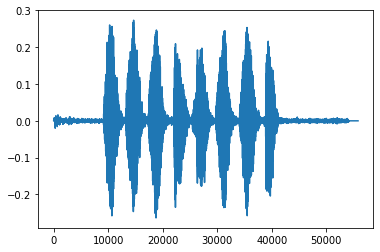

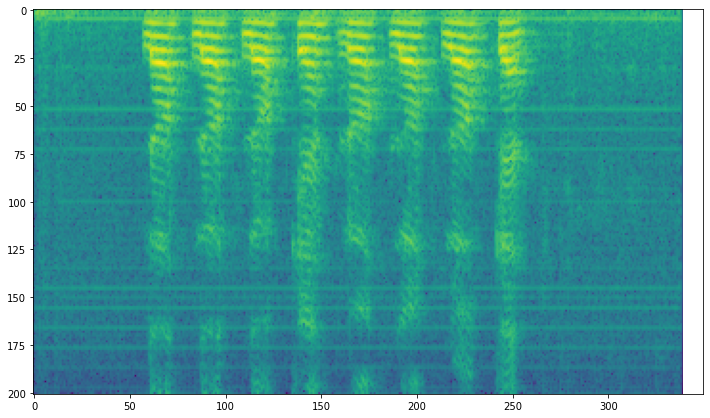

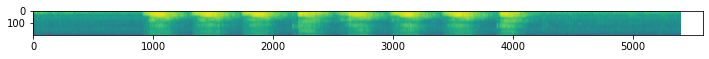

In [11]:
from matplotlib import pyplot as plt
import numpy as np

x, y = next(iter(data_loader))
print(type(x), x.shape)
print(type(y), y.shape)
plt.figure()

# visualize waveform
plt.plot(x[0,0])
plt.figure(figsize=(12,8))

# visualize torchaudio spectrogram
torchaudiospectro = torchaudio.transforms.Spectrogram(n_fft=400, win_length=400, hop_length=160)(x)
plt.imshow(np.log(torchaudiospectro[0,0]))
plt.figure(figsize=(12,8))

# create my spectrogram
from numpy.lib.stride_tricks import as_strided
WSIZE_SEC = 0.025
WSTRIDE_SEC = 0.01
FS = 16000
NFFT = 400
WSIZE = 25 # TODO
WSTRIDE = 10 # TODO
WINDOW = np.hamming(WSIZE) # TODO

def myspectrogram(inp):
  s = inp
  # TODO
  #s = torch.stft(s, n_fft=NFFT, hop_length=160, win_length=WSIZE)
 

  # TODO
  w = (len(s) - (WSIZE - 1) - 1) // WSTRIDE + 1
  X = np.zeros((w , NFFT))
  for i in range(w):
    x_n = s[i*WSTRIDE: i*WSTRIDE + WSIZE]
    X[i] = np.abs( np.fft.fft(x_n * WINDOW, NFFT)) **2 
  X = X[:, : NFFT//2]
  #print(X.shape)  
  return X / np.sqrt((WINDOW ** 2).sum())

myspectro = np.log(myspectrogram(x[0,0])).transpose()
plt.imshow(myspectro)


## 2.2 Mel scale

**Exercise 2 (OPTIONAL, difficult):** implement a Mel scale, compare it to `torchaudio`'s. Compare (with plots and a file) your Mel spectrogram to `torchaudio`'s. Feel free to use Hertz to Mel: $2595 \log_{10}(1 + f/700)$, and remember that filterbanks are triangular, maximum at the center frequency and linear to 0 at the center frequency of the above and below filter.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


ValueError: ignored

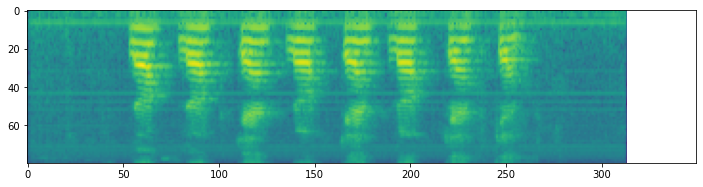

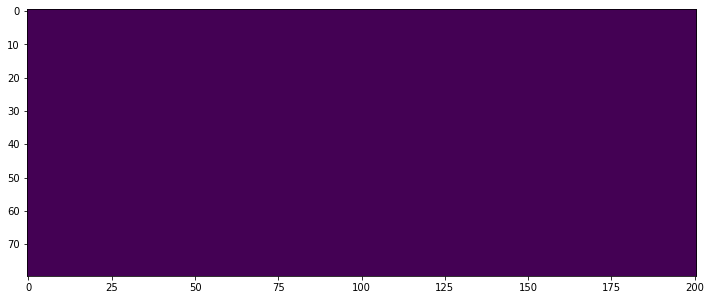

<Figure size 864x576 with 0 Axes>

In [12]:
x, y = next(iter(data_loader))

NMELS = 80

myspectro = np.log(myspectrogram(x[0,0].numpy().astype(np.double))).transpose()

# visualize torchaudio log Melspectrogram
plt.figure(figsize=(12,8))
torchaudiomelspectro = torchaudio.transforms.MelSpectrogram(n_fft=400, win_length=400, hop_length=160, n_mels=NMELS)(x)
plt.imshow(np.log(torchaudiomelspectro[0,0]))

# visualize my Mel scale
plt.figure(figsize=(12,8))
mymelscale = np.zeros((NFFT//2+1, NMELS), dtype=np.double)

def hertz_to_mel(freq):
  mel = 2595*np.log10(1 + freq/700)
  return mel

def mel_to_hertz(mel):
  f = (10**(mel/2595)-1)*700
  return f

# TODO complete your Mel scale (you need to do something like mel_to_hertz(np.linspace(hertz_to_mel(100), hertz_to_mel(8000), TODO)))

plt.imshow(mymelscale.transpose())

# visualize my Melspectrogram PROBABLY QUITE FAR OFF (lots of pre/post processing gain/filters for torchaudio's)
plt.figure(figsize=(12,8))
mymelspectro = np.dot(myspectro.transpose(), mymelscale).clip(1.0e-8, 1.0e8)
plt.imshow(mymelspectro.transpose())


## 2.3 putting it together

**Exercise 3 (OPTIONAL):** redo the training loop from the first lab (1.5), with your log compressed Melspectrogram if you did 2.2, or with powerspectrum if you only did 2.1, as input features.

In [13]:
# TODO (copy from your working 1.5 to get started)

## 2.4 wav-based acoustic model

**Exercice 4:** remove the log Mel filterbanks features in your training loop (section 1.5) and add one convolution (in 1.3) at the very beginnning of the model, that outputs **at the same striding and over the same windows as the Mel filterbanks feature do**. Visualize what you learned for this convolution at the end of training. Hint: you may need to train a bit longer or with a slightly different learning rate than you did in the past.

BONUS: SpecAugment is the same in time, but the frequency masking becomes a [band-stop filter](https://en.wikipedia.org/wiki/Band-stop_filter), you can implement it with scipy/numpy.

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleConvNetWav(nn.Module):
  def __init__(self, kernel_size=3, stride=1, padding=1, depth=5):
    super(SimpleConvNetWav, self).__init__()
    # TODO
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=kernel_size, stride= stride)
    self.conv2 = nn.Conv1d(in_channels=6, out_channels=12, kernel_size=kernel_size, stride= stride)
    
    self.fc1 = nn.Linear(in_features=12 * 60, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=16)
    self.out = nn.Linear(in_features=16, out_features=8)
    self.maxpool = nn.AdaptiveAvgPool1d(60)

  def forward(self, x):

    x = self.conv1(x)
    x = F.relu(x)

    x = self.conv2(x)
    x = F.relu(x)
    
    x = self.maxpool(x)

    x = x.view(x.shape[0], -1)

    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    x = F.relu(x)

    x = self.out(x)
    return x

N_EPOCHS = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleConvNetWav().to(device)  # TODO change hyperparams of SimpleConvNetWav

criterion = nn.MSELoss()  ### TODO ###
optimizer = torch.optim.Adam(model.parameters(),lr= 0.01)

running_loss = 0.0
i = 0
for epoch in range(N_EPOCHS):
  for x, y in data_loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    yhat = model(x)
    loss = criterion(yhat, y.float())
    loss.backward()
    optimizer.step()
    i += 1

    running_loss += loss.item()
    if i % 20 == 0:
      print("loss: %.8f" % (running_loss / 20))
      running_loss = 0.0

loss: 0.29578558
loss: 0.25371403
loss: 0.25013436
loss: 0.25136164
loss: 0.25017290
loss: 0.24916752
loss: 0.24986376
loss: 0.24942114
loss: 0.25082191
loss: 0.25051374
loss: 0.24987366
loss: 0.24985666
loss: 0.24924926
loss: 0.24876494
loss: 0.24737644
loss: 0.24504443
loss: 0.24365373
loss: 0.24062249
loss: 0.23932378
loss: 0.23539874


## 2.5 OPTIONAL: LibriSpeech 100h

If you are patient enough (the training will take many hours even with a small model) you can redo any of the previous training loops on 100h of read English speech, LibriSpeech train-clean-100. And now, you have a dev and test set! (So you can do proper machine learning!) If you do direct classification you could use words as targets, if you're using CTC, you can use letters. **Tip:** if you want to "debug by overfitting", _train_ on the dev (validation) set only.

In [15]:
import os
from typing import Tuple

import torchaudio
from torch import Tensor
from torch.utils.data import Dataset
from torchaudio.datasets.utils import (
  download_url,
  extract_archive,
  walk_files,
)

URL = "train-clean-100"
FOLDER_IN_ARCHIVE = "LibriSpeech"
BASE_URL = "https://dl.fbaipublicfiles.com/librispeech_100h_mp3/"
_CHECKSUMS = {
  BASE_URL + "dev-clean.tar.gz":
  "076916a8f9c61951c5d2e6efaa8d2188232fcf860eec8c074e46edf4fac9623e",
  BASE_URL + "test-clean.tar.gz":
  "3c171e2f1e377e4993c2dbe6bff3f01cd324c0ed462f4de6c78737402a7dbedd",
  BASE_URL + "train-clean-100.tar.gz":
  "7bfbefc680d25ba3a82798ce32c287ea0e82932af1b1f864fae71fb52d2f41f0",
}


def load_librispeech_item(fileid: str, 
                          path: str, 
                          ext_audio: str, 
                          ext_txt: str) -> Tuple[Tensor, int, str, int, int, int]:
  speaker_id, chapter_id, utterance_id = fileid.split("-")

  file_text = speaker_id + "-" + chapter_id + ext_txt
  file_text = os.path.join(path, speaker_id, chapter_id, file_text)

  fileid_audio = speaker_id + "-" + chapter_id + "-" + utterance_id
  file_audio = fileid_audio + ext_audio
  file_audio = os.path.join(path, speaker_id, chapter_id, file_audio)

  # Load audio
  waveform, sample_rate = torchaudio.load(file_audio)

  # Load text
  with open(file_text) as ft:
    for line in ft:
      fileid_text, utterance = line.strip().split(" ", 1)
      if fileid_audio == fileid_text:
        break
    else:
      # Translation not found
      raise FileNotFoundError("Translation not found for " + fileid_audio)

  return (
    waveform,
    sample_rate,
    utterance,
    int(speaker_id),
    int(chapter_id),
    int(utterance_id),
  )


class LIBRISPEECH_100H_MP3(Dataset):
  """
  Create a Dataset for LibriSpeech. Each item is a tuple of the form:
  waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id
  """

  _ext_txt = ".trans.txt"
  _ext_audio = ".mp3"

  def __init__(self,
         root: str,
         url: str = URL,
         folder_in_archive: str = FOLDER_IN_ARCHIVE,
         download: bool = False) -> None:

    if url in [
      "dev-clean",
      "test-clean",
      "train-clean-100",
    ]:

      ext_archive = ".tar.gz"
      base_url = BASE_URL

      url = os.path.join(base_url, url + ext_archive)

    basename = os.path.basename(url)
    archive = os.path.join(root, basename)

    basename = basename.split(".")[0]
    folder_in_archive = os.path.join(folder_in_archive, basename)

    self._path = os.path.join(root, folder_in_archive)

    if download:
      if not os.path.isdir(self._path):
        if not os.path.isfile(archive):
          checksum = _CHECKSUMS.get(url, None)
          download_url(url, root, hash_value=checksum)
        extract_archive(archive)

    walker = walk_files(
      self._path, suffix=self._ext_audio, prefix=False, remove_suffix=True
    )
    self._walker = list(walker)

  def __getitem__(self, n: int) -> Tuple[Tensor, int, str, int, int, int]:
    fileid = self._walker[n]
    return load_librispeech_item(fileid, self._path, self._ext_audio, self._ext_txt)

  def __len__(self) -> int:
    return len(self._walker)


Now you have access to a training set, but also a validation set ("dev" for development) to perform early stopping and hyperparams optimization on (you can look at it e.g. every epoch), and finally a test set (on which you should look at the performance only at the very end, after having completed training).

In [16]:
libri_dev = LIBRISPEECH_100H_MP3(".", url="dev-clean", download=True)

In [17]:
# just so you get an idea of the format 
print(next(iter(libri_dev)))
libri_dev = LIBRISPEECH_100H_MP3(".", url="dev-clean", download=True)

(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0024, -0.0111, -0.0254]]), 16000, 'THEIR MURMURS WERE VARIOUSLY SILENCED BY THE SECTARIES WHO ESPOUSED AND MODIFIED THE DOUBLE SYSTEM OF CERINTHUS', 1673, 143396, 15)


In [18]:
# bigger download, shouuld take 2-3 minutes on Colab
libri_train = LIBRISPEECH_100H_MP3(".", url="train-clean-100", download=True)
libri_test = LIBRISPEECH_100H_MP3(".", url="test-clean", download=True)

In [19]:
# Only use this if your acoustic model outputting words directly
#lexicon = set()
#for utterance in libri_train:  # TODO use parallel Pool.map() and reduce the sets
#  lexicon.update(utterance[2].split())
#print("Lexicon's size: {}".format(len(lexicon)))

In [20]:
# Use this is your acoustic model is outputting letters
tokens_list = list(" ABCDEFGHIJKLMNOPQRSTUVWXYZ")
tokens_set = set(tokens_list)
print(tokens_list)

[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [21]:
def collate_fn_libri(batch):
  #print(batch)
  tensors = [b[0].t() for b in batch if b]
  tensors_len = [len(t) for t in tensors]
  tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
  tensors = tensors.transpose(1, -1)

  transcriptions = [list(b[2].replace("'", " ")) for b in batch if b]
  targets = [torch.tensor([tokens_list.index(e) for e in t]) for t in transcriptions]
  targets_len = [len(t) for t in targets]
  targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

  return tensors, targets, torch.tensor(tensors_len), torch.tensor(targets_len)

train_set = torch.utils.data.DataLoader(libri_train, batch_size=2, shuffle=True,
                                        num_workers=4, collate_fn=collate_fn_libri)

In [22]:
print(next(iter(train_set)))
train_set = torch.utils.data.DataLoader(libri_train, batch_size=16, shuffle=True,
                                        num_workers=2, collate_fn=collate_fn_libri)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0001, 0.0001, 0.0001]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), tensor([[20,  8,  9, 19,  0,  5, 24, 20, 18,  1, 15, 18,  4,  9, 14,  1, 18, 25,
          0,  8,  5, 18,  5, 19, 25,  0,  8,  1,  4,  0,  2,  5,  7, 21, 14,  0,
          9, 14,  0, 20,  8,  5,  0,  5,  1, 19, 20,  0,  1, 14,  4,  0,  8,  1,
          4,  0, 19, 16, 18,  5,  1,  4,  0,  1, 12, 12,  0, 15, 22,  5, 18,  0,
         20,  8,  5,  0,  3,  9, 22,  9, 12,  9, 26,  5,  4,  0, 23, 15, 18, 12,
          4,  0,  9, 20, 19,  0,  6, 15, 12, 12, 15, 23,  5, 18, 19,  0,  6, 15,
         18, 13,  5,  4,  0,  1,  0, 19,  5,  3, 18,  5, 20,  0, 19, 15,  3,  9,
          5, 20, 25,  0, 23,  9, 20,  8,  0, 19,  9,  7, 14, 19,  0,  1, 14,  4,
          0, 16,  1, 19, 19, 23, 15, 18,  4, 19,  0,  7, 18,  1,  4,  5, 19,  0,
          1, 14,  4,  0,  9, 14,  9, 20,  9,  1, 20,  9, 15, 14, 19,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  

# Part 3 End-to-end training

## 3.1 Train with CTC (using PyTorch's implementation)

**Exercise 1:** Train your `SimpleConvNet` with [`nn.CTCLoss`](https://pytorch.org/docs/master/generated/torch.nn.CTCLoss.html). Very hard to get it to converge (on Colab...), but the loss should be going down! That should be your criterion for success. If you're bored of YESNO, you can try LibriSpeech, the simplest is probably to train on the validation set (dev). I included some helper function for that with `collate_fn_libri` but feel free to roll your own.

In [70]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

N_EPOCHS = 500
BATCH_SIZE = 32


def collate_fn_yesno(batch):
  tensors = [b[0].t() for b in batch if b]
  tensors_len = [len(t) for t in tensors]
  tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
  tensors = tensors.transpose(1, -1)

  targets = torch.tensor([b[2] for b in batch if b]) + 1  # you can do it differently than the +1 if you want (it's to add room for the blank label at index 0)
  targets_len = [len(t) for t in targets]
  targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

  return tensors, targets, torch.tensor(tensors_len), torch.tensor(targets_len)

yesno_dataset = YESNO(".", download=True)


### EXPERIMENTAL ###
MAX_X_LEN = 100  # limiting the length of the utterances, play with those
MAX_Y_LEN = 10   # limiting the length of the utterances, play with those
def collate_fn_libri(batch):
  tensors = [b[0][:MAX_X_LEN].t() for b in batch if b]
  tensors_len = [len(t) for t in tensors]
  tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
  tensors = tensors.transpose(1, -1)

  transcriptions = [list(b[2].replace("'", " ")) for b in batch if b]
  targets = [torch.tensor([tokens_list.index(e) for e in t][:MAX_Y_LEN]) for t in transcriptions]
  targets_len = [len(t) for t in targets]
  targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

  return tensors, targets, torch.tensor(tensors_len), torch.tensor(targets_len)

dev_set = torch.utils.data.DataLoader(libri_dev, batch_size=BATCH_SIZE, shuffle=True,
                                      num_workers=4, collate_fn=collate_fn_libri)  # yes, train on the dev set, to debug you model
### /EXPERIMENTAL ###


class SimpleConvNetCTC(nn.Module):
  def __init__(self, kernel_size=3, padding=1, depth=5):
    super(SimpleConvNetCTC, self).__init__()
    ### TODO complete
    self.conv1 = nn.Conv1d(in_channels=80, out_channels=6, kernel_size=kernel_size, stride= 1)
    self.conv2 = nn.Conv1d(in_channels=6, out_channels=12, kernel_size=kernel_size, stride= 1)
    
    self.fc1 = nn.Linear(in_features=12 * 60, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=16)
    self.out = nn.Linear(in_features=16, out_features=8)
    self.maxpool = nn.AdaptiveAvgPool1d(60)

  def forward(self, x):
    x = x.squeeze()
    x = self.conv1(x)
    x = F.relu(x)
    
    x = self.conv2(x)
    x = F.relu(x)
    
    x = self.maxpool(x)
    
    x = x.view(x.shape[0], -1)

    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    x = F.relu(x)
    x = self.out(x)
    #x = F.softmax(x)
    return x


data_loader = torch.utils.data.DataLoader(yesno_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                          num_workers=2, collate_fn=collate_fn_yesno)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleConvNetCTC(kernel_size=5, padding=2, depth=7).to(device)
criterion = nn.CTCLoss(zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(),lr= 0.01)  ### TODO

running_loss = 0.0
i = 0
for epoch in range(N_EPOCHS):
  for x, y, x_len, y_len, in data_loader:  
    x_batch_len = x.shape[-1]
    x = torch.log(1. + melfbanks(x))
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    yhat = model(x).unsqueeze(2)
    yhat = yhat.permute(1,0,2)
    yhat_len = torch.tensor([int(yhat.shape[0]*x_len[i]/x_batch_len) for i in range(yhat.shape[1])]) # this is an approximation, should be good enough
    loss = criterion(yhat,y,yhat_len,y_len) ### TODO
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    i += 1

    running_loss += loss.item()
    if i % 100 == 0:
      print("loss: %.8f" % (running_loss / 20))
      running_loss = 0.0
      #print(yhat[0])
      #print(y[0])

loss: 0.00000000
loss: 0.00000000
loss: 0.00000000
loss: 0.00000000
loss: 0.00000000
loss: 0.00000000
loss: 0.00000000
loss: 0.00000000
loss: 0.00000000
loss: 0.00000000


## 3.2 Implementing CTC

**Exercise 2 (difficult):** Implement your own CTC loss `myCTC`, pass the assert here. Note that the predictions are in log probabilities, not in probabilities. https://distill.pub/2017/ctc/ may be helpful.

In [1]:

import numpy as np
import edit_distance as ed
import heapq as hq

def myCTC(p, y,il , tl, is_prob =False):
    """
    
    CTC loss function.
    params - n x m matrix of n-D probability distributions over m frames.
    seq - sequence of phone id's for given example.
    is_prob - whether params have already passed through a softmax
    Returns objective and gradient.
    """
    blank=0
    tl = y.shape[0] # Length of label sequence (# phones)
    numphones = p.shape[0] # Number of labels
    L = 2*tl + 1 # Length of label sequence with blanks
    il = p.shape[1] # Lengilh of utterance (time)

    alphas = np.zeros((L,il))
    betas = np.zeros((L,il))

    #Keep for gradcheck move this, assume NN outputs probs
    if not is_prob:
        p = p - np.max(p,axis=0)
        p = np.exp(p)
        p = p / np.sum(p,axis=0)
    #print(p)

    # Initialize alphas and forward pass 
    alphas[0,0] = p[blank,0]
    alphas[1,0] = p[y[0],0]
    c = np.sum(alphas[:,0])
    alphas[:,0] = alphas[:,0] / c
    llForward = np.log(c)
    #xrange=range 
    for t in range(1,il):
        start = max(0,L-2*(il-t)) 
        end = min(2*t+2,L)
        for s in range(start,L):
            l = (s-1)//2
            # blank
            if s%2 == 0:
                if s==0:
                    alphas[s,t] = alphas[s,t-1] * p[blank,t]
                else:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * p[int(blank),t]
            # same label twice
            elif s == 1 or y[l] == y[l-1]:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * p[int(y[l]),t]
            else:
                 alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1] + alphas[s-2,t-1]) * p[y[l],t]
            
        # normalize at current time (prevent underflow)
        c = np.sum(alphas[start:end,t])
        alphas[start:end,t] = alphas[start:end,t] / c
        llForward += np.log(c)

    # Initialize betas and backwards pass
    betas[-1,-1] = p[blank,-1]
    betas[-2,-1] = p[y[-1],-1]
    c = np.sum(betas[:,-1])
    betas[:,-1] = betas[:,-1] / c
    llBackward = np.log(c)
    for t in range(il-2,-1,-1):
        start = max(0,L-2*(il-t)) 
        end = min(2*t+2,L)
        for s in range(end-1,-1,-1):
            l = (s-1)//2
            # blank
            if s%2 == 0:
                if s == L-1:
                    betas[s,t] = betas[s,t+1] * p[blank,t]
                else:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * p[blank,t]
            # same label twice
            elif s == L-2 or y[l] == y[l+1]:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * p[y[l],t]
            else:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1] + betas[s+2,t+1]) \
                    * p[y[l],t]

        c = np.sum(betas[start:end,t])
        betas[start:end,t] = betas[start:end,t] / c
        llBackward += np.log(c)

    # Compute gradient with respect to unnormalized input parameters
    grad = np.zeros(p.shape)
    ab = alphas*betas
    for s in range(L):
        # blank
        if s%2 == 0:
            grad[blank,:] += ab[s,:]
            ab[s,:] = ab[s,:]/p[blank,:]
        else:
            grad[y[(s-1)//2],:] += ab[s,:]
            ab[s,:] = ab[s,:]/(p[y[(s-1)//2],:]) 
    absum = np.sum(ab,axis=0)

    # Check for underflow or zeros in denominator of gradient
    llDiff = np.abs(llForward-llBackward)
    if llDiff > 1e-5 or np.sum(absum==0) > 0:
        #print("Diff in forward/backward LL : %f"%llDiff)
        #print("Zeros found : (%d/%d)"%(np.sum(absum==0),absum.shape[0]))
        return -llForward,grad,ilrue

    #grad = p - grad / (p * absum) 
    llForward = torch.tensor(llForward/2)
    
    return llForward
print('l =  ', l)
#assert torch.allclose(l, myCTC(p, y, inp_len, tar_len))

ModuleNotFoundError: ignored

## 3.3 Implementing Beam Search

**Exercise 3 (optional, difficult):** implement (vanilla) beam search, test it on the previous (`y` and `p`) example form 3.2. How can you deal with the blanks? The answer is in https://distill.pub/2017/ctc/